# Experiments with AutoML
## Author: Roberto Olayo Alarcon

Hi! Welcome to my project in AutoML.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from automl import kfold_experiments
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Read Data

Churn data

In [2]:
churn_data = arff.loadarff("data/chrun.arff")
churn_df = pd.DataFrame(churn_data[0])

Ok Cupid data. Takes a bit of time to load.

In [3]:
okcupid_stem = arff.loadarff("data/okcupid_stem.arff")
okcupid_df = pd.DataFrame(okcupid_stem[0])

### Small pre-processing. 

I do a little cleaning of the data before applying any models to them.   

For the **Churn** dataset:  
The columns **class** and **number_customer_service_calls** can be made ints

In [4]:
churn_df["class"] = churn_df["class"].astype(int)
churn_df["number_customer_service_calls"] = churn_df["number_customer_service_calls"].astype(int)

I do a bit more with the **okcupid** dataset:  
Firstly, by manual inspection I saw that some categorical columns can be encoded as an oridinal variable. Here is my attempt to do that for the columns **drinks, drugs, and smokes**.

In [5]:
drinks_dict = {b"not at all": 0,
               b"rarely": 1,
               b"socially": 2,
               b"often":3,
               b"very often": 4,
               b"desperately":5,
               b"?": np.nan}

drugs_dict = {b"never":0,
              b"sometimes": 1,
              b"often": 2,
              b"?": np.nan}

smokes_dict = {b"no": 0,
               b"trying to quit": 1,
               b"when drinking": 2,
               b"sometimes":3,
               b"yes": 4,
              b"?": np.nan}

okcupid_df["drinks"] = okcupid_df["drinks"].apply(drinks_dict.get)
okcupid_df["drugs"] = okcupid_df["drugs"].apply(drugs_dict.get)
okcupid_df["smokes"] = okcupid_df["smokes"].apply(smokes_dict.get)

Next, I decided to convert all of the binary strings into regular strings to make things easier later on.   
Also the '?'are replaced with NaN values.  
Finally, the column **income** is converted into a numeric data type

In [6]:
# A small function to decode bytes
def determine_dtype(x):
    return x.decode("utf-8")

for col in okcupid_df.select_dtypes(include="object").columns:
    okcupid_df[col] = okcupid_df[col].apply(determine_dtype)

okcupid_df.replace('?', np.nan, inplace=True)

okcupid_df["income"] = okcupid_df["income"].astype('float64')

# Experiments

Here we will prepare the 10 fold cross validation experiments to compare our AutoML pipeline to an untuned Random Forrest, and a Voting Classifier

### Churn data experiments

Prepare parameters for the experiments.  
We are going to do **10 fold cross validation**, and maximizing the **negative log loss**.  

In this instance we try out the **Elastic Net, Random Forrest, Gradient Boosting and Stochastic Gradient Descent**.  

For preprocessing we can try out combinations of **Standard Scaling and Min-Max Scaling** for numeric features. For categorical features we can do **One Hot Encoding and Sum Diference Encoding**. We can also do a bit of dimensionality reduction with **Factor Analysis with Mixed Datatypes (FAMD)**.   

We perform 4 halving searches with hyperband, with a fidelity parameter of 2 (eta). 

In [7]:
# Data
X_churn = churn_df.drop(columns="class")
y_churn = np.reshape(churn_df["class"].values, X_churn.shape[0])

# Experiment parameters
kfolds = 10
scorer = "neg_log_loss"
ncores = 50
random_state = 42

# AutoML params
automl_dict = {"classification_algorithms": ["EL", "RF", "GB", "SGD"],
               "numerical_strategies": ["SSE", "MMS"],
               "categorical_strategies": ["OHE", "SUM"],
               "test_fraction": 0.1,
               "cv_folds": 4,
               "dim_reduction": ["FAMD"],
               "n_dims": 20,
               "random_state": random_state,
               "n_searches": 4,
               "fidelity_parameter": 2,
               "n_jobs": ncores,
               "score_function": scorer,
               "optimizer_strategy": "my_hyperband"}

# Voters
voter_clfs = [RandomForestClassifier(random_state=random_state), 
              DecisionTreeClassifier(random_state=random_state),
              GradientBoostingClassifier(random_state=random_state)]

In [8]:
# Run the experiment
churn_experiment, churn_automl, churn_internal = kfold_experiments(X_churn, y_churn, kfolds, scorer, automl_dict, voter_clfs,
                                                  n_cores=ncores, random_state=42)

Fold 0


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]
Data-Model combinations: 1it [00:08,  8.19s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]
Data-Model combinations: 2it [00:15,  7.82s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
Data-Model combinations: 3it [00:20,  6.41s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
Data-Model combinations: 4it [00:21,  4.30s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]
Data-Model combinations: 5it [00:25,  4.01s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]
Data-Model combinations: 6it [00:32,  5.20s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
Data-Model combinations: 7it [00:37,  5.04s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
Data-Model combinations: 8it [00:38,  3.76s/it]
Hyperband iterations: 100%|█

Fold 1


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations:  25%|██▌       | 1/4 [00:02<00:06,  2.11s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██████████| 4/4 [00:08<00:00,  2.13s/it]
Data-Model combinations: 1it [00:08,  8.53s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it]
Data-Model combinations: 2it [00:16,  7.96s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]
Data-Model combinations: 3it [00:21,  6.72s/it

Fold 2


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:  50%|█████     | 2/4 [00:02<00:02,  1.21s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]
Data-Model combinations: 1it [00:05,  5.73s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.86s/it]
Data-Model combinations: 2it [00:13,  6.75s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]
Data-Model combinations: 3it [00:18,  5.87s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
Data-Model combinations: 4it [00:19,  3.99s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
Data-Model combinations: 5it [00:22,  3.83s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

Fold 3


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]
Data-Model combinations: 1it [00:11, 11.23s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]
Data-Model combinations: 2it [00:19,  9.33s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]
Data-Model combinations: 3it [00:23,  7.19s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]
Data-Model combinations: 4it [00:24,  4.76s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
Data-Model combinations: 5it [00:28,  4.35s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]
Data-Model combinations: 6it [00:36,  5.55s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]
Data-Model combinations: 7it [00:41,  5.25s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]
Data-Model combinations: 8it [00:42,  3.91s/it]
Hyperband iterations: 100%|█

Fold 4


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations:  25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]
Data-Model combinations: 1it [00:06,  6.21s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]
Data-Model combinations: 2it [00:14,  7.26s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]
Data-Model combinations: 3it [00:18,  6.07s/it

Fold 5


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:  50%|█████     | 2/4 [00:03<00:02,  1.46s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]
Data-Model combinations: 1it [00:06,  6.27s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.91s/it]
Data-Model combinations: 2it [00:13,  7.09s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]
Data-Model combinations: 3it [00:18,  6.01s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]
Data-Model combinations: 4it [00:19,  4.05s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
Data-Model combinations: 5it [00:23,  3.85s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

Fold 6


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]
Data-Model combinations: 1it [00:07,  7.16s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]
Data-Model combinations: 2it [00:15,  7.64s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]
Data-Model combinations: 3it [00:19,  6.28s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
Data-Model combinations: 4it [00:20,  4.22s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
Data-Model combinations: 5it [00:24,  3.98s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]
Data-Model combinations: 6it [00:32,  5.31s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
Data-Model combinations: 7it [00:37,  5.12s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.84it/s]
Data-Model combinations: 8it [00:38,  3.82s/it]
Hyperband iterations: 100%|█

Fold 7


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]
Data-Model combinations: 1it [00:05,  5.95s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]
Data-Model combinations: 2it [00:13,  7.05s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]
Data-Model combinations: 3it [00:18,  6.06s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]
Data-Model combinations: 4it [00:19,  4.09s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]
Data-Model combinations: 5it [00:23,  3.88s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]
Data-Model combinations: 6it [00:30,  5.20s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]
Data-Model combinations: 7it [00:35,  5.01s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]
Data-Model combinations: 8it [00:36,  3.74s/it]
Hyperband iterations: 100%|█

Fold 8


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:  50%|█████     | 2/4 [00:06<00:06,  3.15s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]
Data-Model combinations: 1it [00:10, 10.13s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it]
Data-Model combinations: 2it [00:17,  8.73s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]
Data-Model combinations: 3it [00:22,  6.90s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]
Data-Model combinations: 4it [00:23,  4.58s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
Data-Model combinations: 5it [00:27,  4.20s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

Fold 9


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:  50%|█████     | 2/4 [00:03<00:03,  1.91s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]
Data-Model combinations: 1it [00:07,  7.67s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it]
Data-Model combinations: 2it [00:15,  7.80s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]
Data-Model combinations: 3it [00:20,  6.42s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]
Data-Model combinations: 4it [00:21,  4.30s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
Data-Model combinations: 5it [00:24,  4.03s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

In [10]:
churn_experiment.to_csv("output/churn_experiments.tsv.gz", sep='\t')
churn_automl.to_csv("output/churn_automl.tsv.gz", sep='\t')

### okcupid experiments

Prepare parameters for the experiments.  
We are going to do **10 fold cross validation**, and maximizing the **negative log loss**.  

In this instance we try out the **Elastic Net, Random Forrest, Gradient Boosting, Stochastic Gradient Descent, and a Decision Tree**.  

This dataset has a lot of categorical variables that contain more than one category. If we apply simple One Hot Encoding or Sum Difference we would end up with over 7,000 features! This makes the process of learning really slow. Therefore it makes sense to apply some more aggresive dimensionalty reduction. For preprocessing we can try out combinations of **Standard Scaling followed by variance thresholding** for numeric features. For categorical features we can do **One Hot Encoding followed by variance threshold**. We can also do a bit of dimensionality reduction with **Factor Analysis with Mixed Datatypes (FAMD)**.   

We perform 4 halving searches with hyperband, with a fidelity parameter of 2 (eta). 

Also, I train and test the Random Forrest and Majority voter with the preprocessing steps of the best pipeline found by the AutoML tool. This is because the models have a hard time dealing with non-numeric entries and it also speeds up the runtime of the experiment

In [11]:
# Data
X_cupid = okcupid_df.drop(columns="job")
y_cupid = np.reshape(okcupid_df["job"].values, X_cupid.shape[0])

In [12]:
# Experiment parameters
kfolds = 10
scorer = "neg_log_loss"
ncores = 50
random_state = 11

# AutoML params
automl_dict = {"classification_algorithms": ["GB", "RF", "DT", "SGD", "EL"],
               "numerical_strategies": ["SSE_VAR"],
               "categorical_strategies": ["OHE_VAR"],
               "dim_reduction": ["FAMD"],
               "n_dims": 20,
               "test_fraction": 0.1,
               "cv_folds": 5,
               "random_state": random_state,
               "n_searches": 4,
               "fidelity_parameter": 2,
               "n_jobs": ncores,
               "score_function": scorer,
               "optimizer_strategy": "my_hyperband"}

# Voters
voter_clfs = [RandomForestClassifier(random_state=random_state), 
              DecisionTreeClassifier(random_state=random_state),
              GradientBoostingClassifier(random_state=random_state)]

In [13]:
cupid_experiment, cupid_automl, cupid_interal = kfold_experiments(X_cupid, y_cupid, kfolds, scorer, automl_dict, voter_clfs,
                                                  n_cores=ncores, random_state=42, use_processor=True)

Fold 0


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.20s/it]
Data-Model combinations: 1it [00:32, 32.81s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]
Data-Model combinations: 2it [00:44, 20.10s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]
Data-Model combinations: 3it [00:48, 13.19s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]
Data-Model combinations: 4it [00:55, 10.52s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:55<00:00, 13.91s/it]
Data-Model combinations: 5it [01:51, 26.80s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:44<00:00, 26.14s/it]
Data-Model combinations: 6it [03:35, 53.24s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.53s/it]
Data-Model combinations: 7it [03:49, 40.46s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]
Data-Model combinations: 8it [03:55, 29.55s/it]
Hyperband iterations: 100%|█

Fold 1


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.18s/it]
Data-Model combinations: 1it [00:32, 32.73s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:11<00:00,  2.78s/it]
Data-Model combinations: 2it [00:43, 20.03s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]
Data-Model combinations: 3it [00:49, 13.32s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]
Data-Model combinations: 4it [00:55, 10.64s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:52<00:00, 13.17s/it]
Data-Model combinations: 5it [01:48, 25.80s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:43<00:00, 25.91s/it]
Data-Model combinations: 6it [03:32, 52.27s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.56s/it]
Data-Model combinations: 7it [03:46, 39.84s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]
Data-Model combinations: 8it [03:52, 29.06s/it]
Hyperband iterations: 100%|█

Fold 2


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.19s/it]
Data-Model combinations: 1it [00:32, 32.78s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.75s/it]
Data-Model combinations: 2it [00:43, 19.98s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]
Data-Model combinations: 3it [00:48, 13.19s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]
Data-Model combinations: 4it [00:55, 10.59s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:01<00:00, 15.32s/it]
Data-Model combinations: 5it [01:56, 28.87s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:43<00:00, 25.99s/it]
Data-Model combinations: 6it [03:40, 54.40s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]
Data-Model combinations: 7it [03:54, 41.25s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]
Data-Model combinations: 8it [04:00, 29.97s/it]
Hyperband iterations: 100%|█

Fold 3


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.23s/it]
Data-Model combinations: 1it [00:32, 32.94s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]
Data-Model combinations: 2it [00:43, 19.91s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]
Data-Model combinations: 3it [00:48, 13.18s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]
Data-Model combinations: 4it [00:56, 11.01s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:59<00:00, 14.97s/it]
Data-Model combinations: 5it [01:56, 28.64s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:43<00:00, 25.93s/it]
Data-Model combinations: 6it [03:40, 54.17s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]
Data-Model combinations: 7it [03:54, 41.22s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]
Data-Model combinations: 8it [04:00, 30.06s/it]
Hyperband iterations: 100%|█

Fold 4


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:34<00:00,  8.61s/it]
Data-Model combinations: 1it [00:34, 34.46s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]
Data-Model combinations: 2it [00:45, 20.57s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]
Data-Model combinations: 3it [00:50, 13.52s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]
Data-Model combinations: 4it [00:57, 10.99s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:56<00:00, 14.12s/it]
Data-Model combinations: 5it [01:54, 27.40s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:43<00:00, 25.99s/it]
Data-Model combinations: 6it [03:38, 53.43s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]
Data-Model combinations: 7it [03:52, 40.60s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]
Data-Model combinations: 8it [03:58, 29.65s/it]
Hyperband iterations: 100%|█

Fold 5


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:33<00:00,  8.28s/it]
Data-Model combinations: 1it [00:33, 33.13s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]
Data-Model combinations: 2it [00:44, 20.14s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]
Data-Model combinations: 3it [00:49, 13.40s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]
Data-Model combinations: 4it [00:56, 10.95s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:55<00:00, 13.93s/it]
Data-Model combinations: 5it [01:52, 27.09s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:44<00:00, 26.10s/it]
Data-Model combinations: 6it [03:36, 53.39s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.55s/it]
Data-Model combinations: 7it [03:51, 40.58s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]
Data-Model combinations: 8it [03:57, 29.66s/it]
Hyperband iterations: 100%|█

Fold 6


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.11s/it]
Data-Model combinations: 1it [00:32, 32.44s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]
Data-Model combinations: 2it [00:43, 19.96s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]
Data-Model combinations: 3it [00:49, 13.35s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]
Data-Model combinations: 4it [00:56, 10.95s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:57<00:00, 14.30s/it]
Data-Model combinations: 5it [01:53, 27.64s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:44<00:00, 26.12s/it]
Data-Model combinations: 6it [03:38, 53.76s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.53s/it]
Data-Model combinations: 7it [03:52, 40.81s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]
Data-Model combinations: 8it [03:58, 29.78s/it]
Hyperband iterations: 100%|█

Fold 7


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.17s/it]
Data-Model combinations: 1it [00:32, 32.69s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]
Data-Model combinations: 2it [00:43, 20.07s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]
Data-Model combinations: 3it [00:49, 13.24s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]
Data-Model combinations: 4it [00:55, 10.76s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:56<00:00, 14.08s/it]
Data-Model combinations: 5it [01:52, 27.19s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:44<00:00, 26.04s/it]
Data-Model combinations: 6it [03:36, 53.37s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.53s/it]
Data-Model combinations: 7it [03:50, 40.54s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]
Data-Model combinations: 8it [03:56, 29.58s/it]
Hyperband iterations: 100%|█

Fold 8


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.22s/it]
Data-Model combinations: 1it [00:32, 32.88s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]
Data-Model combinations: 2it [00:43, 19.96s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]
Data-Model combinations: 3it [00:48, 13.20s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]
Data-Model combinations: 4it [00:56, 10.78s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:55<00:00, 13.87s/it]
Data-Model combinations: 5it [01:51, 26.90s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:43<00:00, 25.95s/it]
Data-Model combinations: 6it [03:35, 53.05s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.55s/it]
Data-Model combinations: 7it [03:49, 40.36s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]
Data-Model combinations: 8it [03:55, 29.42s/it]
Hyperband iterations: 100%|█

Fold 9


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.19s/it]
Data-Model combinations: 1it [00:32, 32.75s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:11<00:00,  2.77s/it]
Data-Model combinations: 2it [00:43, 20.01s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]
Data-Model combinations: 3it [00:49, 13.29s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]
Data-Model combinations: 4it [00:56, 10.87s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:14<00:00, 18.61s/it]
Data-Model combinations: 5it [02:10, 33.80s/it]
Hyperband iterations: 100%|██████████| 4/4 [01:43<00:00, 25.93s/it]
Data-Model combinations: 6it [03:54, 57.57s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:14<00:00,  3.58s/it]
Data-Model combinations: 7it [04:08, 43.43s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]
Data-Model combinations: 8it [04:14, 31.48s/it]
Hyperband iterations: 100%|█

In [14]:
cupid_experiment.to_csv("output/cupid_experiment.tsv.gz", sep='\t')
cupid_automl.to_csv("output/cupid_automl.tsv.gz", sep='\t')

# Optimization trace

## Comparing K fold performance

Let's take a look at how our pipeline performs!

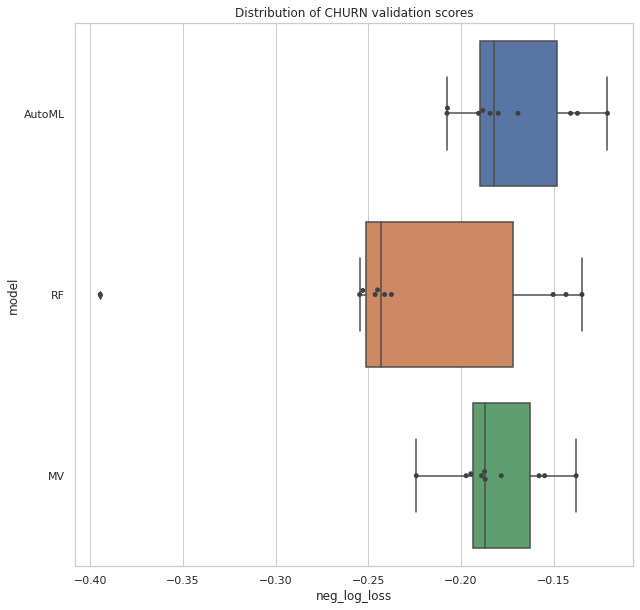

In [15]:
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")
# plot boxplot
bp = sns.boxplot(x=f"{scorer}", y="model", data=churn_experiment)
bp = sns.swarmplot(x=f"{scorer}", y="model", data=churn_experiment, color=".25")
plt.title("Distribution of CHURN validation scores")
bp.get_figure().savefig("output/base_boxplot.pdf", bbox_inches='tight')

From the image above, it seems that our pipeline is the best median performer, with the Majority Voter being a very close second place. In all honesty these two are quite similar. The worst, and most erratic performer in this experiment was the Random Forrest.

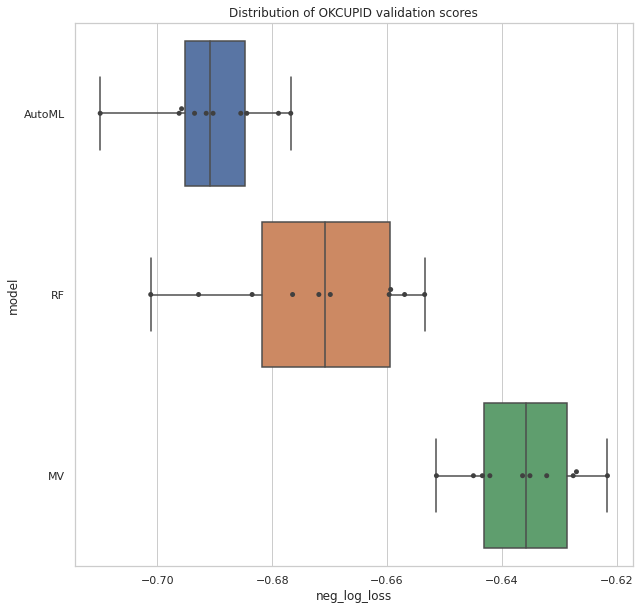

In [16]:
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")
# plot boxplot
bp = sns.boxplot(x=f"{scorer}", y="model", data=cupid_experiment)
bp = sns.swarmplot(x=f"{scorer}", y="model", data=cupid_experiment, color=".25")
plt.title("Distribution of OKCUPID validation scores")
bp.get_figure().savefig("output/base_boxplot.pdf", bbox_inches='tight')

Suprisingly (at least to me), it seems that my AutoML pipeline is the worst performer when it comes to the OkCupid dataset D:   

This is notable to me, since a Random Forrest was included in the search space of the pipeline, yet the Random Forrest model trained as a comparison seems to always outperform my pipeline. The best performer is the Majority Voter.   

Still, it is worth noticing that these negative log loss test scores are quite poor for all models, at least in comparison to the Churn results above. Then again, this was a more complicated task

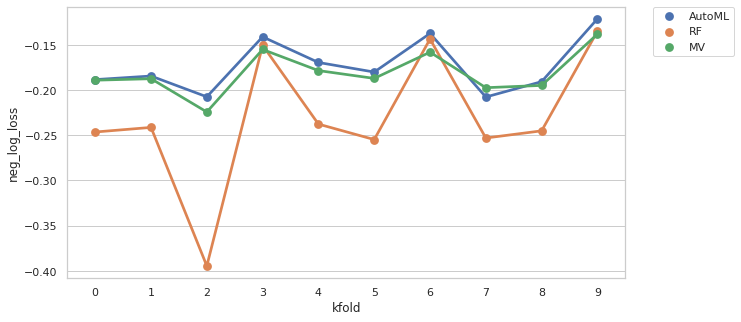

In [17]:
plt.figure(figsize=(10,5))
scorer="neg_log_loss"
g = sns.pointplot(data=churn_experiment, x="kfold", y=f"{scorer}", hue="model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

g.get_figure().savefig("output/churn_kfold.pdf", bbox_inches='tight')

Looking at the individual validation errors, we notice that the all follow the same trend, and my AutoML pipeline is the top performer in most cases. Though it is followed very closely by the Majority Voter

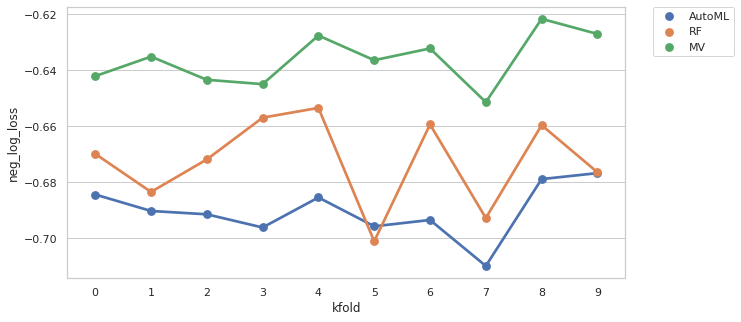

In [18]:
plt.figure(figsize=(10,5))
scorer="neg_log_loss"
g = sns.pointplot(data=cupid_experiment, x="kfold", y=f"{scorer}", hue="model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.get_figure().savefig("output/cupid_kfold.pdf", bbox_inches='tight')

Here we can see that the Random Forrest is more erratic across folds, while the AutoML pipeline and the Majority Voter have more stable behaviours. Still, it is quite clear that there is some distance between the AutoML and the Majority Voter. Maybe the Majority Voter should be included in the AutoML pipeline hehe. But this is really notable because they were all trained on the same pre-processed data

## Which model is selected?

We can take a look at what strategies were successful across the different folds in our AutoML pipeline

In [19]:
# Gather the top performers
churn_champions = churn_automl[churn_automl["overall_champion"] == "overall_champion"]
cupid_champions = cupid_automl[cupid_automl["overall_champion"] == "overall_champion"]

In [20]:
# Count the frequency with which each model is selected
churn_selected_models = pd.DataFrame(churn_champions[["combination",
                              "kfold"]].drop_duplicates()["combination"].value_counts()).reset_index()

churn_selected_models.rename(columns={"index": "selected_combination",
                                      "combination": "frequency"}, inplace=True)

cupid_selected_models = pd.DataFrame(cupid_champions[["combination", 
                              "kfold"]].drop_duplicates()["combination"].value_counts()).reset_index()

cupid_selected_models.rename(columns={"index": "selected_combination",
                                      "combination": "frequency"}, inplace=True)

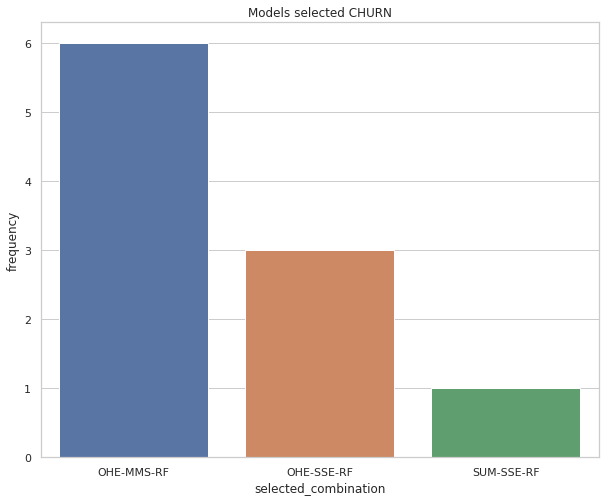

In [21]:
plt.figure(figsize=(10,8))
g = sns.barplot(data=churn_selected_models, x="selected_combination", y="frequency")
plt.title("Models selected CHURN")
g.get_figure().savefig("output/churn_selected_models.pdf", bbox_inches='tight')

Interesting! It seems that a Random Forrest is always selected for the Churn task. A representation with One Hot Encoding seems to be a good idea. The numerical strategies seem to include all possibilities.  
  
It is interesting to see that a Random Forrest is selected, while the untuned Random Forrest was the worst performed. Talk about the importance of tuning!

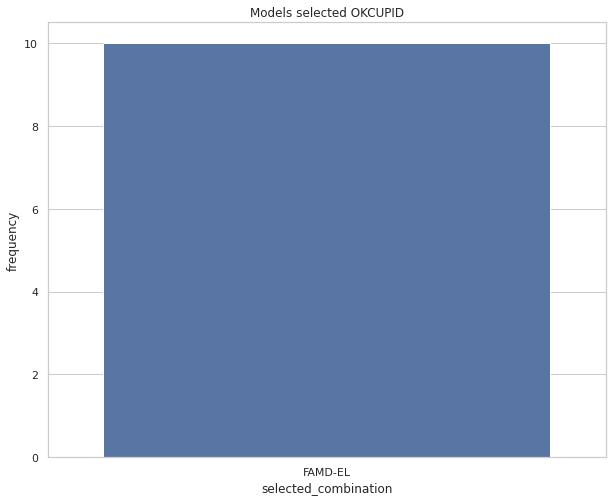

In [22]:
plt.figure(figsize=(10,8))
g = sns.barplot(data=cupid_selected_models, x="selected_combination", y="frequency")
plt.title("Models selected OKCUPID")
g.get_figure().savefig("output/cupid_selected_models.pdf", bbox_inches='tight')

This is quite unexpected. It seems that across all folds, the model selected was an elastic net! FAMD decomposition seems to work better than variance thresholding.   

This interesting, as this was one of the more simple models included in the search space. Maybe there is a problem of overfitting for the more complex models 

# Internal optimization

We can take a look at how the SCORE changes across the iterations of Hyperband

### Score evolution by each Successive Halving iteration

<Figure size 720x720 with 0 Axes>

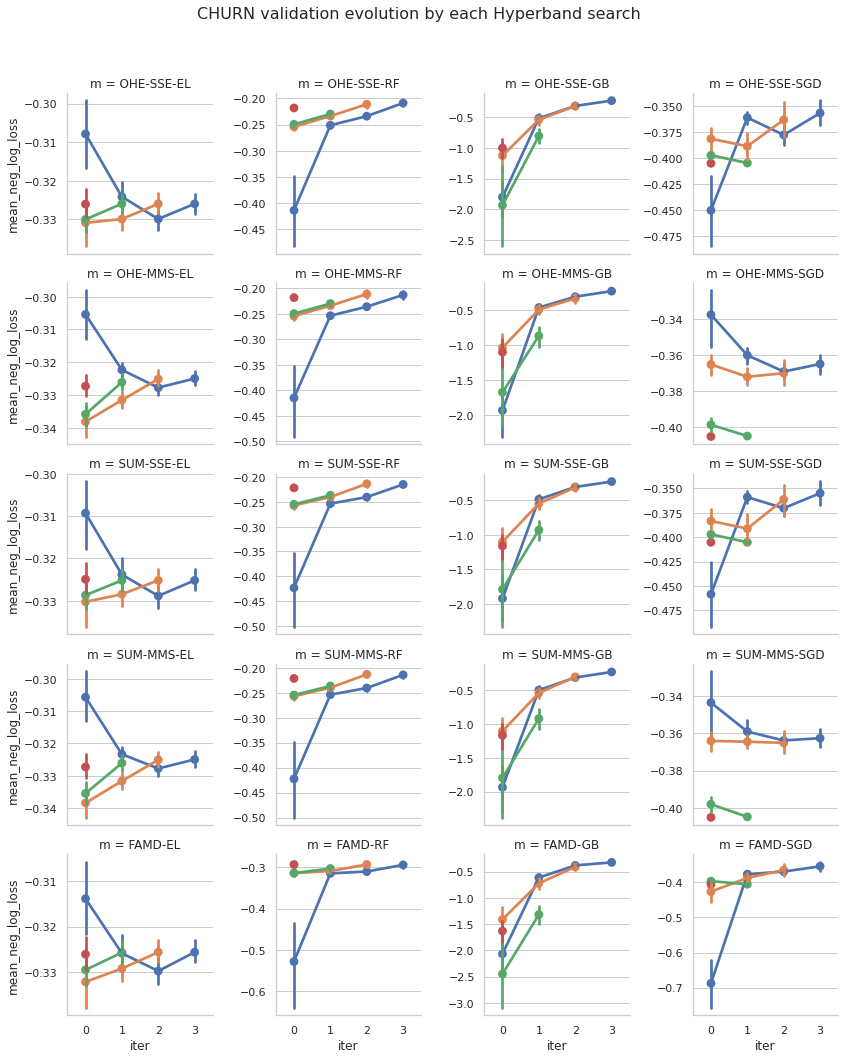

In [42]:
plt.figure(figsize=(10,10))
churn_automl.rename(columns={"mean_test_score": "mean_neg_log_loss", 
                             "combination": "m"}, inplace=True)
g = sns.FacetGrid(churn_automl, col="m", col_wrap=4, hue="hyperband_iter", sharey=False)
g.map(sns.pointplot, "iter", "mean_neg_log_loss", order=[0,1,2,3], hue_order=[0,1,2,3])
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('CHURN validation evolution by each Hyperband search', fontsize=16)
g.savefig("output/churn_hyperband_by_model.pdf", bbox_inches="tight")

Here we can see that succesive iterations of Halving Search yield an improvement in the overall score for most models. The exception seems to be elastic net, which has more trouble generalizing once it receives more data. Also, the best model is almost always found in the first Hyperbrand bracket.   

If one takes a closer look at the scale of the y-axis, we can see the Gradient Boosting and Stochastic Gradient Descent have more trouble generalizing, while Elastic Net and Random Forrest perform better out of the box

<Figure size 720x720 with 0 Axes>

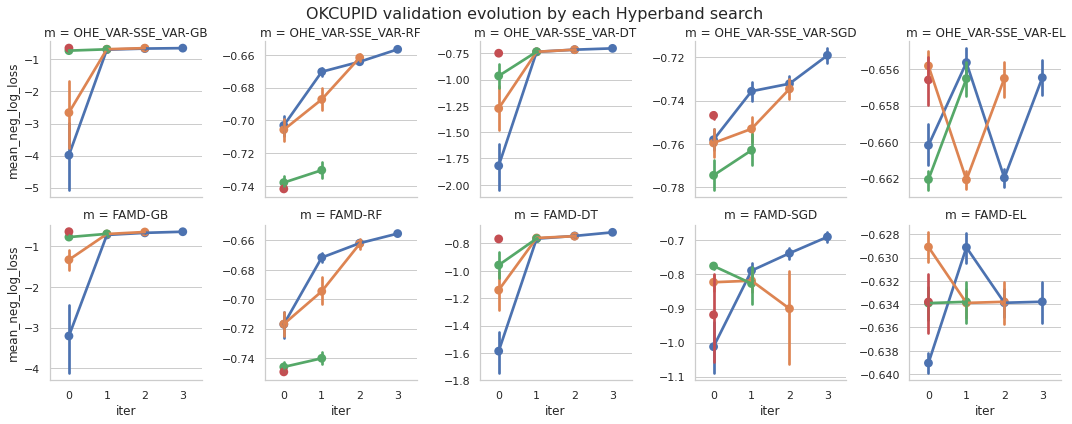

In [24]:
plt.figure(figsize=(10,10))
cupid_automl.rename(columns={"mean_test_score": "mean_neg_log_loss", 
                             "combination": "m"}, inplace=True)
g = sns.FacetGrid(cupid_automl, col="m", col_wrap=5, hue="hyperband_iter", sharey=False)
g.map(sns.pointplot, "iter", "mean_neg_log_loss", order=[0,1,2,3], hue_order=[0,1,2,3])
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('OKCUPID validation evolution by each Hyperband search', fontsize=16)
g.savefig("output/cupid_hyperband_by_model.pdf", bbox_inches="tight")

Similar to above, succesive iterations of Halving Search yield an improvement in the overall score for most models. Interstingly, Elastic Net again seems to have trouble generalizing once it receives more data, yet yields a better out of box performance, in comparison to the other, more complex models. This might indicate overfitting in the more complex models. It might be worth tuning class weights.

# Evolution of best test score

We can see how the best score changes at each iteration of the Succesive Halving search in the hyperband

In [25]:
# Gather the average best score across folds for each hyperband iteration
churn_avg = pd.DataFrame(churn_automl.groupby(["kfold", "hyperband_iter", "iter"])["mean_neg_log_loss"].max()).reset_index()
churn_avg = pd.DataFrame(churn_avg.groupby(["hyperband_iter", "iter"])["mean_neg_log_loss"].mean()).reset_index()


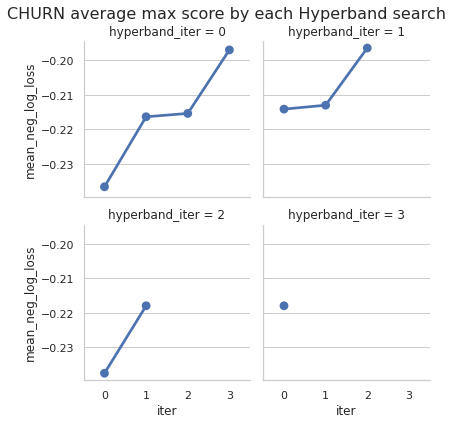

In [26]:
g = sns.FacetGrid(churn_avg, col="hyperband_iter", col_wrap=2, sharey=True)
g.map(sns.pointplot, "iter", "mean_neg_log_loss", order=[0,1,2,3])
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('CHURN average max score by each Hyperband search', fontsize=16)
g.savefig("output/churn_hyperband_by_iter.pdf", bbox_inches="tight")

As expected, the best score improves, the more iterations we perform

In [27]:
cupid_avg = pd.DataFrame(cupid_automl.groupby(["kfold", "hyperband_iter", "iter"])["mean_neg_log_loss"].max()).reset_index()
cupid_avg = pd.DataFrame(cupid_avg.groupby(["hyperband_iter", "iter"])["mean_neg_log_loss"].mean()).reset_index()


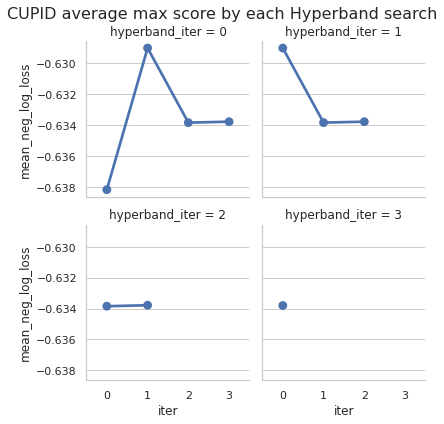

In [28]:
g = sns.FacetGrid(cupid_avg, col="hyperband_iter", col_wrap=2, sharey=True)
g.map(sns.pointplot, "iter", "mean_neg_log_loss", order=[0,1,2,3])
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('CUPID average max score by each Hyperband search', fontsize=16)
g.savefig("output/cupid_hyperband_by_iter.pdf", bbox_inches="tight")

Here there is not such a clear pattern as in the previous plot. It seems that once the models receive more data, they have trouble generalizing. I really wonder why that is. Why doesn't a Random Forrest perform as well when trained on all data, in comparison to the out-of-box Random Forrest?

In [29]:
churn_havg = pd.DataFrame(churn_automl.groupby(["kfold", "hyperband_iter"])["mean_neg_log_loss"].max()).reset_index()
churn_havg = pd.DataFrame(churn_havg.groupby("hyperband_iter")["mean_neg_log_loss"].mean()).reset_index()

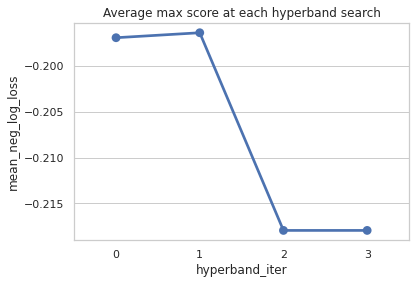

In [30]:
g = sns.pointplot(data=churn_havg, y="mean_neg_log_loss", x="hyperband_iter")
plt.title("Average max score at each hyperband search")
g.get_figure().savefig("output/churn_avg_hyperband.pdf", bbox_inches="tight")

We gather that the score is better in the first iterations of hyperband, when we begin with more candidates

In [31]:
cupid_havg = pd.DataFrame(cupid_automl.groupby(["kfold", "hyperband_iter"])["mean_neg_log_loss"].max()).reset_index()
cupid_havg = pd.DataFrame(cupid_havg.groupby("hyperband_iter")["mean_neg_log_loss"].mean()).reset_index()

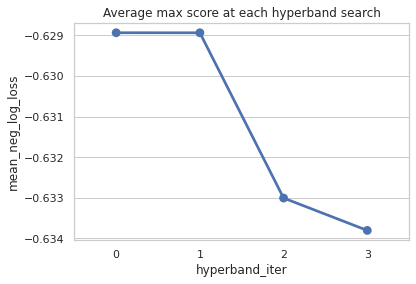

In [32]:
g=sns.pointplot(data=cupid_havg, y="mean_neg_log_loss", x="hyperband_iter")
plt.title("Average max score at each hyperband search")
g.get_figure().savefig("output/cupid_avg_hyperband.pdf", bbox_inches="tight")

Again, we gather that the score is better in the first iterations of hyperband, when we begin with more candidates. It might be worth populating the later iterations with more models, so as to get a situation more similar to the out-of-box classifiers.

It could also be that my implementation of hyperband is somehow failing. Will have to do a comparison to HpBandSterSearch